In [10]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10836115160152738207
xla_global_id: -1
]


2022-02-10 00:28:11.653204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 00:28:11.654370: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Folders Setup

In [16]:
path = os.getcwd()
data = os.path.join(path,'data')

def folder_setup():
    """ works for linux only

    """
    df = pd.read_csv("train.csv")
    classes = df["label"].drop_duplicates().values.tolist()
    os.mkdir(os.path.join(path,'data'))
    
    # create classes folder
    for classe in classes :
        os.mkdir(os.path.join(path,'data',classe))

    # copy the image in the right classes folder
    for index, values in df.iterrows():
        os.system(f"cp {os.path.join(path,values[1])} {os.path.join(path,'data',values[2],values[1].split('/')[1])}")  

In [19]:
#folder_setup()

FileExistsError: [Errno 17] File exists: '/home/tanguy/Documents/challenge/data'

## Classes and weights

In [20]:
class_weight = {}
total = 0
for index,c in enumerate(sorted(os.listdir(data))):
    weight = len(os.listdir(os.path.join(data,c)))
    class_weight[index] = weight
    total += weight

class_weight = dict(map(lambda k_v:(k_v[0],1-k_v[1]/total),class_weight.items()))
classes = sorted(os.listdir(data))
classes

['aluminium_foil',
 'carton',
 'chips_bag',
 'drink_carton',
 'glass_bottle',
 'metal_bottle_cap',
 'metal_can',
 'paper',
 'paper_cup',
 'paper_tissues',
 'plastic_bag',
 'plastic_bottle',
 'plastic_bottle_cap',
 'plastic_container',
 'plastic_cup',
 'plastic_lid',
 'plastic_straw',
 'plastic_tableware',
 'styrofoam']

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 


## Create the dataset for training and validation

In [14]:
img_size = (256,256)
batch_size = 16

train_ds = keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,
    seed=3777,
    subset="training").prefetch(buffer_size=batch_size)

val_ds = keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.85,
    seed=3777,
    subset="validation").prefetch(buffer_size=batch_size)


Found 1643 files belonging to 19 classes.
Using 1397 files for training.
Found 1643 files belonging to 19 classes.
Using 1396 files for validation.


## Data augmentation

In [37]:
from tensorflow.keras import layers
#data_augmentation = keras.Sequential(
#    [
#        layers.RandomFlip("horizontal"),
#        layers.RandomRotation(0.1),
#    ]
#)

## Display some images

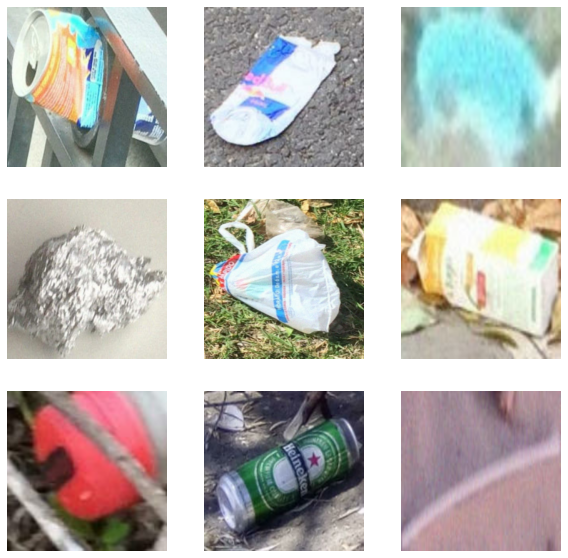

In [38]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

### To keep the same shape everywhere

In [40]:
keras.backend.set_image_data_format('channels_last')

### Transfer learning with EfficientNetB4 

In [41]:
from tensorflow.keras.applications import EfficientNetB4
input_shape = (img_size[0],img_size[0],3)

# get efficientNetB4 layer
efficientNetB4 = EfficientNetB4(weights='imagenet', input_shape=input_shape, include_top=False)

# We dont want to change the wait from efficientNetB4
efficientNetB4.trainable = False


model = Sequential([
    efficientNetB4,
    GlobalAveragePooling2D(),
    Dense(19, activation="softmax")
])

In [42]:
Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(img_size[0],img_size[0],3), activation="relu"),
    Conv2D(32, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(64, (3,3), padding='same', activation="relu"),
    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(128, (3,3), padding='same', activation="relu"),
    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(256, (3,3), padding='same', activation="relu"),
    Conv2D(256, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(512, (3,3), padding='same', activation="relu"),
    Conv2D(512, (3,3), activation="relu"),
    
    Flatten(),
    Dense(256,activation="relu"),
    Dropout(0.2),
    Dense(19, activation="softmax")
])


model.summary() # To check our model!

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 19)                34067     
                                                                 
Total params: 17,707,890
Trainable params: 34,067
Non-trainable params: 17,673,823
_________________________________________________________________


In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor=np.sqrt(0.1),
            patience=10,
            min_lr=0.5e-6)

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)
early_stoping = EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
)


In [45]:
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [46]:
history = model.fit(train_ds,
               epochs=150,
               validation_data=val_ds,
               callbacks=[reduce_lr,checkpointer, early_stoping],
               class_weight=class_weight)

Epoch 1/150
88/88 [==============================] - ETA: 0s - loss: 1.9840 - accuracy: 0.4087
Epoch 1: val_loss improved from inf to 1.46607, saving model to model.hdf5
88/88 [==============================] - 417s 5s/step - loss: 1.9840 - accuracy: 0.4087 - val_loss: 1.4661 - val_accuracy: 0.6254 - lr: 0.0010
Epoch 2/150
88/88 [==============================] - ETA: 0s - loss: 1.2525 - accuracy: 0.6314
Epoch 2: val_loss improved from 1.46607 to 1.12360, saving model to model.hdf5
88/88 [==============================] - 406s 5s/step - loss: 1.2525 - accuracy: 0.6314 - val_loss: 1.1236 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 3/150
88/88 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.7008
Epoch 3: val_loss improved from 1.12360 to 0.93978, saving model to model.hdf5
88/88 [==============================] - 398s 5s/step - loss: 0.9898 - accuracy: 0.7008 - val_loss: 0.9398 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 4/150
88/88 [==============================] - 

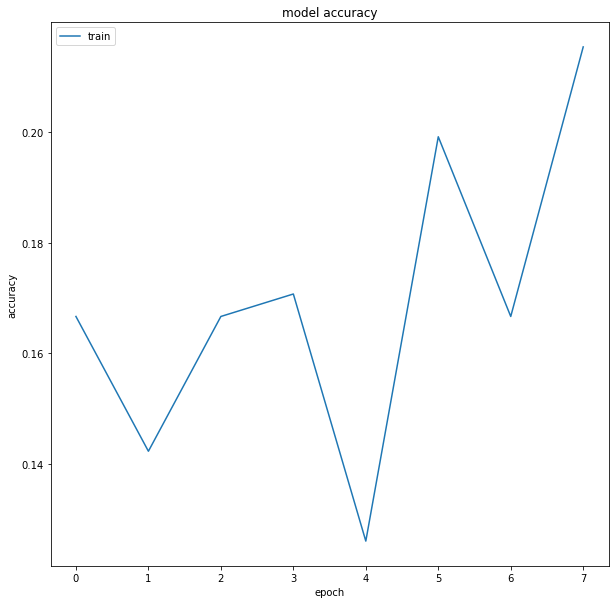

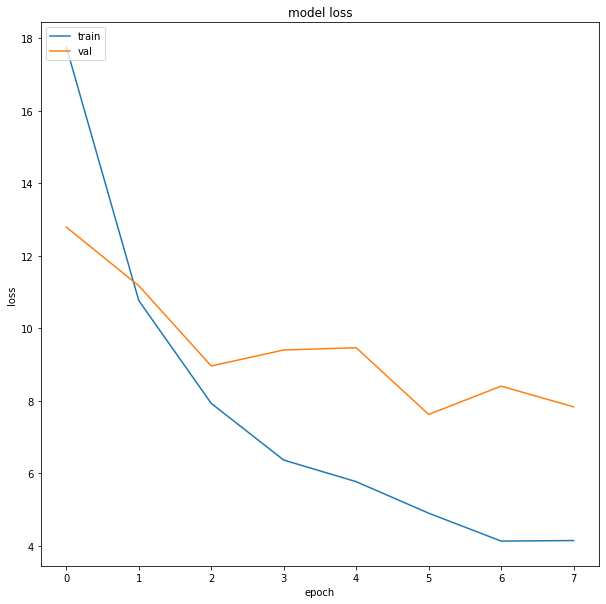

In [ ]:
def plot_history(history):
    """
    Plot the loss & accuracy
    """
    plt.figure(figsize=[10,10])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=[10,10])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history)

In [ ]:
def do_prediction():
    # prediction
    model.load_weights('model.hdf5')
    from random import randint
    name_img = os.listdir(os.path.join(path,'test'))[randint(0,387)]
    random_path_img = os.path.join(path,'test',name_img)
    image_array = cv2.imread(random_path_img, cv2.IMREAD_COLOR) # Loading the image
    image_array = cv2.resize(image_array, (img_size[0], img_size[0])) # Resize the image
    #image = cv2.imread(random_path_img)
    #cv2.imshow('image',image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    scores = model.predict(np.array([image_array]))
    classes = sorted(os.listdir(data))
    print(f'{name_img} -> {classes[scores.argmax(axis=-1)[0]]} {scores.max()}\n\n')
    for c,p in zip(classes,scores[0]):
        print(f'{c} prediction : {p}')





In [22]:
def test_predictions():
    model = keras.models.load_model('model.hdf5')
    with open("test_predictions.csv","w") as file :
        images = []
        test_dir = os.listdir(os.path.join(path,'test'))
        file.write("index,path,pred\n")
        for img in test_dir:
            image_array = cv2.imread(os.path.join(path,'test',img), cv2.IMREAD_COLOR) # Loading the image
            images.append(cv2.resize(image_array, (img_size[0], img_size[0]))) # Resize the image
        scores = model.predict(np.array(images))
        for s,img in zip(scores.argmax(axis=-1),test_dir) :
            classe = classes[s]
            file.write(f"{img.split('.')[0]},train/{img},{classe}\n")

        
test_predictions()
